# 📘 Fraud Detection in E-commerce - ML Project

In [10]:
# 📌 Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from google.colab import files
import io
import warnings
warnings.filterwarnings("ignore")

# 📌 Step 2: Upload Dataset
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[file_name]))

# 📌 Step 3: Preprocessing
if 'PDate' in df.columns:
    df['PDate'] = pd.to_datetime(df['PDate'], errors='coerce')
    df['Day'] = df['PDate'].dt.day
    df['Month'] = df['PDate'].dt.month
    df['Weekday'] = df['PDate'].dt.weekday
    df['Is_Weekend'] = df['Weekday'].apply(lambda x: 1 if x >= 5 else 0)
    df.drop(columns=['PDate'], inplace=True)

df['Amount'].fillna(df['Amount'].median(), inplace=True)
df['Amount_Log'] = np.log1p(df['Amount'])

for col in ['Order_ID', 'SKU', 'ASIN']:
    if col in df.columns:
        df.drop(columns=col, inplace=True)

df['currency'].fillna('Unknown', inplace=True)
df.dropna(inplace=True)

# Encode categorical features
cat_cols = df.select_dtypes(include='object').columns
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# 📌 Step 4: Feature Scaling
X = df.drop('Label', axis=1)
y = df['Label']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 📌 Step 5: Isolation Forest
iso_model = IsolationForest(n_estimators=300, contamination=0.4, random_state=42)
iso_model.fit(X_scaled)

# Predict anomalies
y_pred_iso = iso_model.predict(X_scaled)
df['anomaly_label'] = np.where(y_pred_iso == -1, 1, 0)
df['anomaly_score'] = iso_model.decision_function(X_scaled)

# 📌 Step 6: Evaluate Isolation Forest Alone
print("📊 Isolation Forest Report:")
print(classification_report(y, df['anomaly_label']))
print("Confusion Matrix:\n", confusion_matrix(y, df['anomaly_label']))

# 📌 Step 7: Train-Test Split for Supervised Model (with anomaly features)
features = df.drop('Label', axis=1)
labels = df['Label']

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, stratify=labels, random_state=42
)

# 📌 Step 8: Train XGBoost on Anomaly-Enhanced Features
xgb = XGBClassifier(n_estimators=500, max_depth=8, learning_rate=0.05,
                    use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# 📌 Step 9: Evaluate XGBoost
print("\n📊 XGBoost on Anomaly-Enhanced Features:")
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_xgb))


Saving Datasets.csv to Datasets (13).csv
📊 Isolation Forest Report:
              precision    recall  f1-score   support

           0       0.53      0.60      0.56      1360
           1       0.48      0.40      0.44      1244

    accuracy                           0.51      2604
   macro avg       0.50      0.50      0.50      2604
weighted avg       0.51      0.51      0.50      2604

Confusion Matrix:
 [[821 539]
 [741 503]]

📊 XGBoost on Anomaly-Enhanced Features:
              precision    recall  f1-score   support

           0       0.51      0.54      0.52       272
           1       0.46      0.43      0.45       249

    accuracy                           0.49       521
   macro avg       0.49      0.49      0.48       521
weighted avg       0.49      0.49      0.49       521

Confusion Matrix:
 [[146 126]
 [141 108]]
ROC AUC Score: 0.48524982282069457


In [9]:
# Create anomaly feature
df['anomaly_score'] = iso_model.decision_function(X_scaled)
df['anomaly_label'] = y_pred  # From Isolation Forest

# Now train XGBoost on X + anomaly features
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

features = df.drop('Label', axis=1)
labels = df['Label']

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)

xgb = XGBClassifier(n_estimators=500, max_depth=8, learning_rate=0.05, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
print("📊 XGBoost on Anomaly-Enhanced Features:")
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred))


📊 XGBoost on Anomaly-Enhanced Features:
              precision    recall  f1-score   support

           0       0.51      0.55      0.53       272
           1       0.46      0.42      0.44       249

    accuracy                           0.49       521
   macro avg       0.49      0.49      0.49       521
weighted avg       0.49      0.49      0.49       521

ROC AUC: 0.486578667611623


In [12]:
print(df.columns.tolist())


['Status', 'Fulfilment', 'Sales_Channel ', 'ship_service_level', 'Style', 'Category', 'PSize', 'Qty', 'currency', 'Amount', 'payment_by', 'ship_city', 'ship_state', 'ship_postal-code', 'ship_country', 'Label', 'Day', 'Month', 'Weekday', 'Is_Weekend', 'Amount_Log', 'anomaly_label', 'anomaly_score']


In [13]:
# Add predictions to df (optional: copy X_test first)
df_result = X_test.copy()
df_result['Prediction'] = y_pred


In [16]:
from sklearn.ensemble import IsolationForest

# Step 1: Select numeric features only
feature_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Step 2: Train Isolation Forest (or re-train)
model = IsolationForest(contamination=0.1, random_state=42)
model.fit(df[feature_cols])

# Step 3: Add scores and predictions
df['Fraud_Score'] = model.decision_function(df[feature_cols])
df['Prediction'] = df['Fraud_Score'].apply(lambda x: 'Fraud' if x < -0.05 else 'Normal')


In [17]:
df['Fraud_Score'] = model.decision_function(df[feature_cols])
df['Prediction'] = df['Fraud_Score'].apply(lambda x: 'Fraud' if x < -0.05 else 'Normal')


<Axes: xlabel='Risk_Level', ylabel='count'>

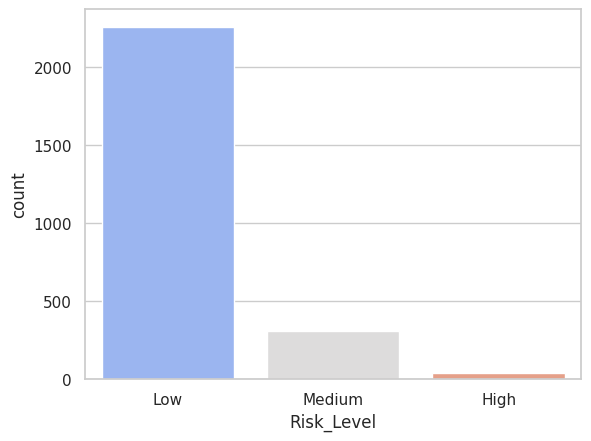

In [21]:
sns.countplot(data=df, x='Risk_Level', palette='coolwarm')


<Axes: xlabel='Fraud_Score', ylabel='Count'>

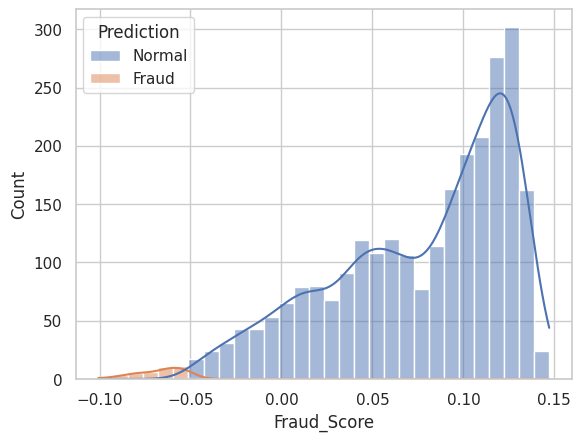

In [24]:
sns.histplot(data=df, x='Fraud_Score', hue='Prediction', bins=30, kde=True)


<Axes: xlabel='Risk_Level', ylabel='Fraud_Score'>

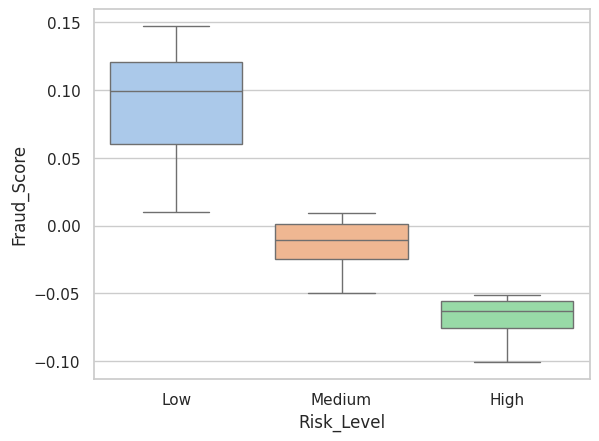

In [25]:
sns.boxplot(data=df, x='Risk_Level', y='Fraud_Score', palette='pastel')


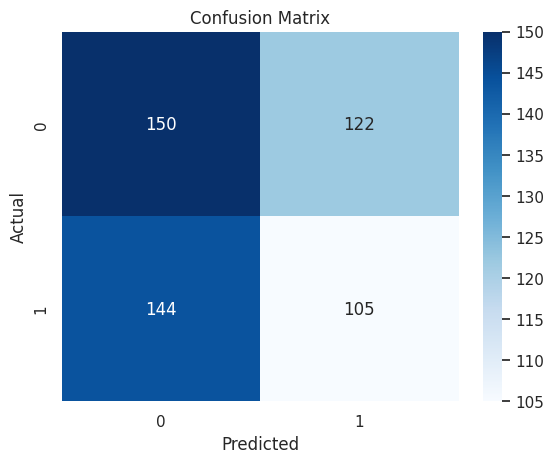

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
